In [1]:
import csv
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from centrex_tlf import couplings, hamiltonian, lindblad, states, transitions, utils
from labellines import labelLine, labelLines
from scipy.integrate import trapezoid

from centrex_tlf_julia_extension import lindblad_julia

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
transition_params = [["R", 0, 3 / 2, 2]]


In [4]:
trans = []
for t, J, F1, F in transition_params:
    trans.append(
        transitions.OpticalTransition(
            getattr(transitions.OpticalTransitionType, t),
            J_ground=J,
            F1_excited=F1,
            F_excited=F,
        )
    )

In [5]:
polarizations = [[couplings.polarization_Z]] * len(trans)

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [6]:
# ignore small decay to J=6
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
c:\Users\ogras\Documents\GitHub\CeNTREX-TlF-julia-extension\.venv\Lib\site-packages\centrex_tlf\couplings\collapse.py:64: UserWarning: Branching ratio sum > 1, difference = 2.22e-16
  warnings.warn(
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [7]:
odepars = lindblad_julia.odeParameters(
    Ω0=hamiltonian.Γ,
    δ0=0.0,  # detuning of the laser [rad/s]
    PZ0=1.0,
)

In [8]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=6
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break

In [9]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F1 = 3/2, F = 2>"
states,
"|X, J = 0>",0.479679
"|X, J = 2>",0.520321


In [10]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

,"|B, J = 1, F1 = 3/2, F = 2>"
states,
"|X, J = 0, F1 = 1/2, F = 1>",0.479679
"|X, J = 2, F1 = 3/2, F = 1>",0.011839
"|X, J = 2, F1 = 3/2, F = 2>",0.102838
"|X, J = 2, F1 = 5/2, F = 2>",0.028282
"|X, J = 2, F1 = 5/2, F = 3>",0.377361


In [11]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)

In [12]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.B), obe_system.QN
)

In [13]:
odepars.Ω0 = 0.0

In [14]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 2e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-7, reltol=1e-4, abstol=1e-7, save_everystep=True, callback=None
)

In [15]:
results = lindblad_julia.do_simulation_single(problem, config=config)

# photons = 1.0


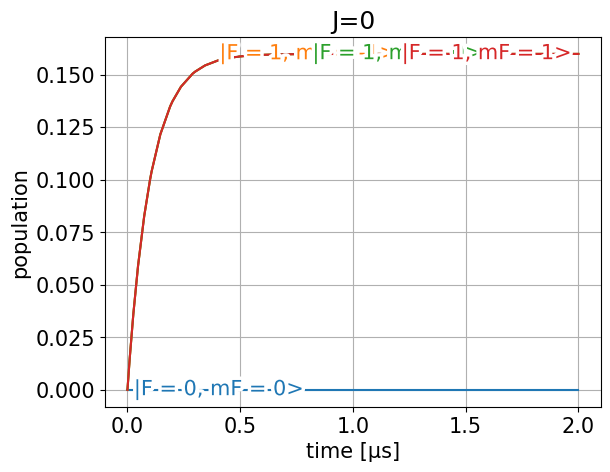

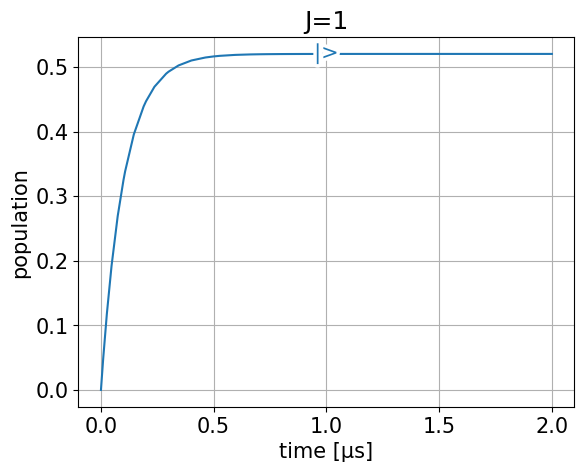

In [16]:
for J, ind in enumerate([indices_J0, indices_J2]):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")


In [17]:
from scipy.optimize import curve_fit


def exp_fit(t, τ):
    return np.exp(-t / τ)


popt, pcov = curve_fit(
    exp_fit, results.t, results.y[indices_excited].sum(axis=0), p0=[1e-6]
)

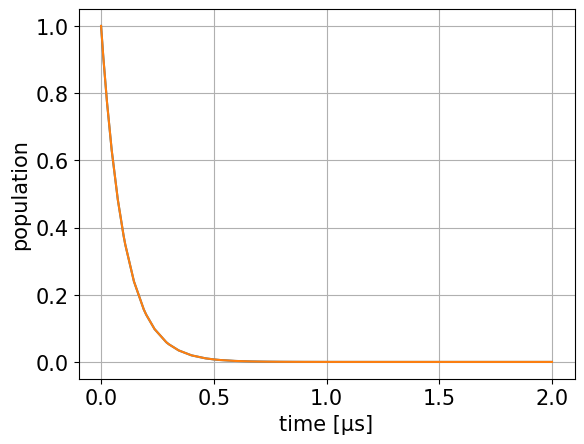

In [18]:
fig, ax = plt.subplots()

ax.plot(results.t * 1e6, results.y[indices_excited].sum(axis=0))
ax.plot(results.t * 1e6, exp_fit(results.t, *popt))

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

In [19]:
print(f"lifetime = {popt[0] * 1e9:.1f} ns")

lifetime = 102.0 ns


In [20]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=1, electronic=states.ElectronicState.X), obe_system.QN
)

In [21]:
odepars.Ω0 = 1 * hamiltonian.Γ

In [22]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-7, reltol=1e-4, abstol=1e-7, save_everystep=True, callback=None
)

In [23]:
results = lindblad_julia.do_simulation_single(problem, config=config)

# photons = 1.92


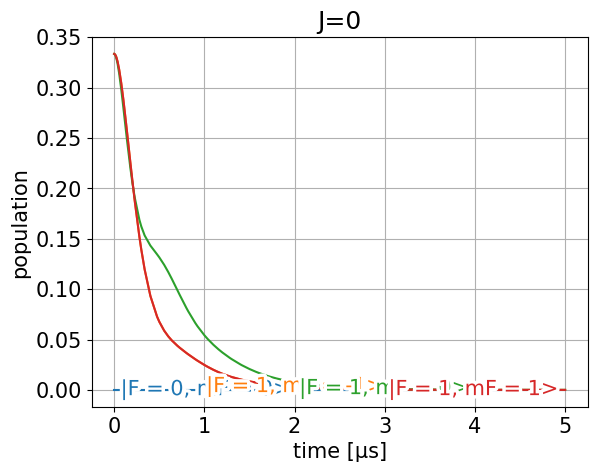

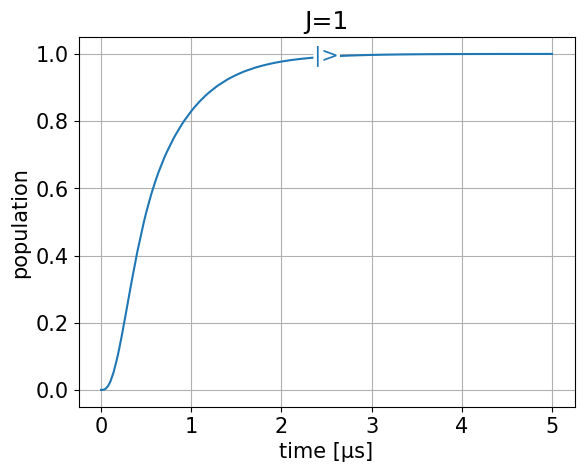

In [24]:
for J, ind in enumerate([indices_J0, indices_J2]):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.2f}")


In [25]:
output_func = lindblad_julia.setup_state_integral_calculation(
    [6, 7, 8, 9, 10], nphotons=True
)
ens_prob = lindblad_julia.OBEEnsembleProblem(
    problem,
    parameters=["Ω0", "δ0"],
    scan_values=[
        np.linspace(1e-3, 3, 201) * 2 * np.pi * 1.56e6,
        np.linspace(-10, 10, 101) * 2 * np.pi * 1.56e6,
    ],
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(ens_prob)

ens_config = lindblad_julia.OBEEnsembleProblemConfig(
    saveat=1e-7, reltol=1e-4, abstol=1e-7, save_everystep=True, callback=None
)

In [26]:
lindblad_julia.solve_problem_parameter_scan(ens_prob, ens_config)

In [27]:
scan_res = lindblad_julia.get_results_parameter_scan(ens_prob, 11 * 15)

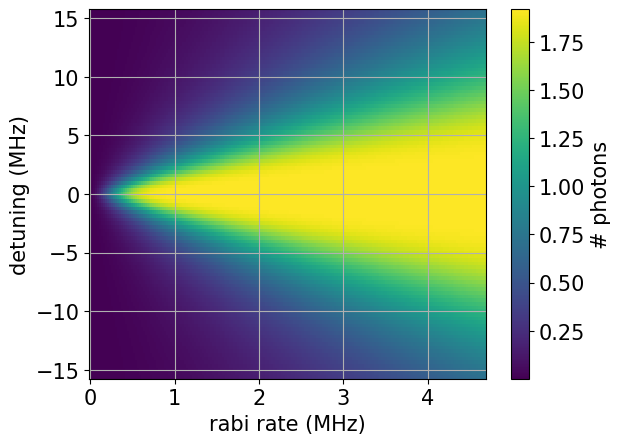

In [28]:
fig, ax = plt.subplots()
pmesh = ax.pcolormesh(
    *np.array(scan_res.scan_values) / (2 * np.pi * 1e6), scan_res.results
)

fig.colorbar(pmesh, label="# photons")

ax.set_xlabel("rabi rate (MHz)")
ax.set_ylabel("detuning (MHz)")

ax.grid()